In [1]:

from esmvalcore.config import CFG
from esmvalcore.dataset import Dataset

CFG.load_from_file('/home/189/fc6164/esmValTool/config-fc-copy.yml')

### Datasets

In [2]:

obs = Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    timerange="1900/2019",
    tier=2)
# list(obs.from_files())
len(obs.files)

2

In [3]:

## model
var = Dataset(
    short_name='tos',
    mip='Omon',
    project='CMIP6',
    activity='CMIP',
    dataset='ACCESS-CM2',
    ensemble='r1i1p1f1',
    institute='*',
    grid='*',
    exp='historical',
    # timerange='1979/2019',
    # derive='true'
)

var_noarea = var.copy()

var.add_supplementary(short_name='areacello', mip='Ofx')
var.find_files()
# list(var.from_files())[0].files
var.files,var.supplementaries[0].files


([LocalFile('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Omon/tos/gn/v20191108/tos_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc')],
 [LocalFile('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Ofx/areacello/gn/v20191108/areacello_Ofx_ACCESS-CM2_historical_r1i1p1f1_gn.nc')])

Regridding:
model and observations regridded toward a generic 1°x1° grid (using cdms esmf linear method)

Steps (computation):

Niño3.4 SSTA
- seasonal cycle removed
- detrending (if applicable)
- smoothed with time running average
- spatial average

SSTA along the equator

- seasonal cycle removed
- detrending (if applicable)
- smoothed with time running average
- regridding (if applicable)
- meridional average
- smoothed with zonal running average

ENSO events
- detect December Niño3.4 SSTA < -0.75std (> 0.75std)

Diversity
- detect the zonal location of the maximum SSTA during all El Niño peak (December)
- detect the zonal location of the minimum SSTA during all La Niña peak (December)
- compute interquartile range (IQR) of the distribution of locations
- abs((model-ref)/ref)*100

In [4]:
import iris
from esmvalcore.preprocessor import (
                detrend, # dimension, method, 
                meridional_statistics, # 
                zonal_statistics,
                area_statistics,
                regrid, #esmf bilinear
                mask_landsea,
                anomalies,
                extract_month, 
                mask_inside_range, mask_above_threshold, mask_below_threshold,
                extract_region, # equatorial pacific #1 - 150°E-90°W, zonal 5°S-5°N average
                climate_statistics,# month mean, standard deviation
                rolling_window_statistics) 

import numpy as np
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs


In [5]:
from esmvalcore.preprocessor import mask_above_threshold, mask_below_threshold
## 
def nino3_4ssta(cube):
    cube = extract_region(cube, 190, 240, -5, 5) #
    # cube = detrend(cube, dimension='time', method='linear') #? like anomalies?
    # cube = regrid(cube, target_grid="1x1", scheme="linear")   
    
    # triangle weighted?- double smoothed
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    
    cube = area_statistics(cube, 'mean') #Multi-dimensional coordinate not supported: 'latitude'
    
    cube = extract_month(cube, 12)
    cube = anomalies(cube, period='monthly', standardize=True)  #normalise
  
    return cube


def eq_ssta(cube):
    cube = extract_region(cube, 150, 270, -5, 5)
    # season cycle? detrend? #convert units
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = extract_month(cube, 12)
    cube = anomalies(cube,period='monthly')
    cube = regrid(cube, target_grid="1x1", scheme="linear") #error regridding
    
    cube = meridional_statistics(cube, 'mean') # ? drop for 3d data to splice by time events?
     # weighted running average 5-degree
    cube = rolling_window_statistics(cube, coordinate='longitude', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='longitude', operator='mean', window_length=5)
    return cube


def enso_events(cube):

    # mean, std = cube.data.mean(), cube.data.std() #normalised, use 0.75
    # range1, range2 = mean-0.75*std, mean + 0.75*std 
    
    a_events = mask_to_years(mask_above_threshold(cube.copy(), -0.75))
    o_events = mask_to_years(mask_below_threshold(cube.copy(), 0.75))
    return {'nina':a_events, 'nino':o_events}

def mask_to_years(events):
    # build time with mask
    maskedTime = np.ma.masked_array(events.coord('time').points, mask=events.data.mask)
    print(f'cube shape: {events.shape}')
    # return years
    return [events.coord('time').units.num2date(time).year for time in maskedTime.compressed()]

# Diversity - get zonal location of max and min
def diversity(ssta_cube, events_dict): #2 masks/events list
    # each enso year, max/min SSTA, get longitude
    res_lon = {}
    for enso, events in events_dict.items():
        year_enso = iris.Constraint(time=lambda cell: cell.point.year in events)
        cube = ssta_cube.extract(year_enso) #or extract preprocesssor?
        if enso == 'nina':
            cube = cube * -1
        #iterate through cube, each time get max/min value and return lon
        loc_ls = []
        for yr_slice in cube.slices(['longitude']):

            indx = np.argmax(yr_slice.data) # if nina multiply by -1 or min
            loc_ls.append(cube.coord('longitude').points[indx])

        res_lon[enso] = loc_ls

    return res_lon # return data to plot 

# IQR and abs((model-ref)/ref)*100
def iqr(data):
    #calculate interquartile range 
    q3, q1 = np.percentile(data, [75 ,25])
    print(q3, q1)
    iqr = q3 - q1
    return iqr
    
def compute(obs_iqr, mod_iqr):
    return abs((mod_iqr-obs_iqr)/obs_iqr)*100

In [9]:
datasets = [var, obs]

#plot 1
process = {}
metric = []
for ds in datasets:
    nino_res = nino3_4ssta(ds.load())
    events = enso_events(nino_res)

    eq_res = eq_ssta(ds.load())
    results_lon = diversity(eq_res, events)
    enso = results_lon['nino'] + results_lon['nina']
    print(ds['dataset'], 'enso IQR:', iqr(enso))
    process[ds['dataset']] = results_lon + [enso]
    metric.append(iqr(enso))

print('metric: ', compute(metric[1],metric[0]))



/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along second dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along second dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along first dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully d

cube shape: (164,): length of data mask: 164
cube shape: (164,): length of data mask: 164


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'longitude' were ignored in the rolling window operation.
  warnings.warn(


245.5 219.0
ACCESS-CM2 26.5
245.5 219.0


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


cube shape: (119,): length of data mask: 119
cube shape: (119,): length of data mask: 119


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(


235.5 194.5
NOAA-ERSSTv5 41.0
235.5 194.5


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'longitude' were ignored in the rolling window operation.
  warnings.warn(


35.36585365853659

{'whiskers': [<matplotlib.lines.Line2D at 0x14b323383990>,
 'caps': [<matplotlib.lines.Line2D at 0x14b3233aa710>,
 'boxes': [<matplotlib.lines.Line2D at 0x14b323381b10>,
 'medians': [<matplotlib.lines.Line2D at 0x14b3233aa510>,
 'fliers': [<matplotlib.lines.Line2D at 0x14b3233a8650>,
 'means': []}

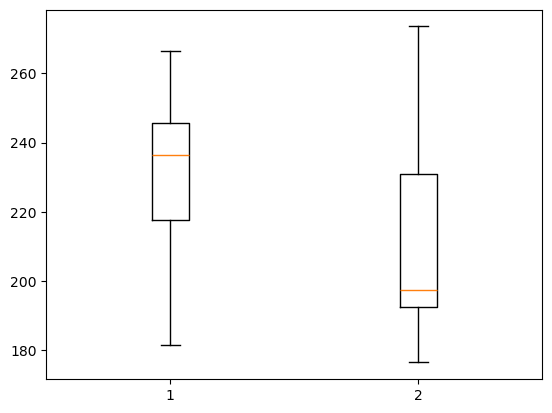

In [18]:
metric
# compute(metric[1],metric[0])
abs((26.5-41.0)/41.0)
nina = [process[ds][0] for ds in process.keys()] #
plt.boxplot(nina)

In [55]:
print(events)
out = diversity(cube, events)
iqr(out[1]), iqr(out[0])


{'nina': [1860, 1865, 1867, 1870, 1876, 1878, 1883, 1885, 1886, 1891, 1892, 1894, 1906, 1912, 1916, 1919, 1921, 1925, 1930, 1936, 1947, 1949, 1955, 1962, 1971, 1973, 1977, 1979, 1982, 1986, 1991, 1996, 2006, 2012], 'nino': [1851, 1852, 1861, 1866, 1869, 1871, 1877, 1890, 1893, 1897, 1905, 1909, 1915, 1918, 1924, 1926, 1933, 1935, 1940, 1941, 1948, 1950, 1954, 1960, 1968, 1972, 1978, 1983, 1985, 1990, 1999, 2002, 2004, 2005, 2009, 2011]}
245.75 228.0
245.5 217.75


(17.75, 27.75)

In [ ]:
nino_cube = nino3_4ssta(var.load())

events = enso_events(nino_cube)

cube = eq_ssta(var.load())

print('max:', cube.data.max(),' min:',cube.data.min(),cube.units)

results_lon = diversity(cube, events)
iqr(results_lon[0]), iqr(results_lon[1])
enso = results_lon[0] + results_lon[1]
iqr(enso)

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along second dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along second dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along first dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully d

cube shape: (164,): length of data mask: 164
cube shape: (164,): length of data mask: 164


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(


max: 2.7579265  min: -2.5888195 degC
245.5 217.75
245.75 228.0
245.5 219.0


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'longitude' were ignored in the rolling window operation.
  warnings.warn(


26.5

{'whiskers': [<matplotlib.lines.Line2D at 0x14fd80e5d110>,
 'caps': [<matplotlib.lines.Line2D at 0x14fd80e5e310>,
 'boxes': [<matplotlib.lines.Line2D at 0x14fd80e5c910>,
 'medians': [<matplotlib.lines.Line2D at 0x14fd8323f290>,
 'fliers': [<matplotlib.lines.Line2D at 0x14fd80ea2350>,
 'means': []}

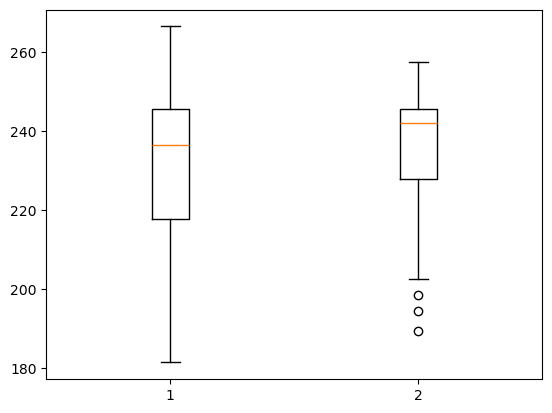

In [57]:
plt.boxplot(results_lon)

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(


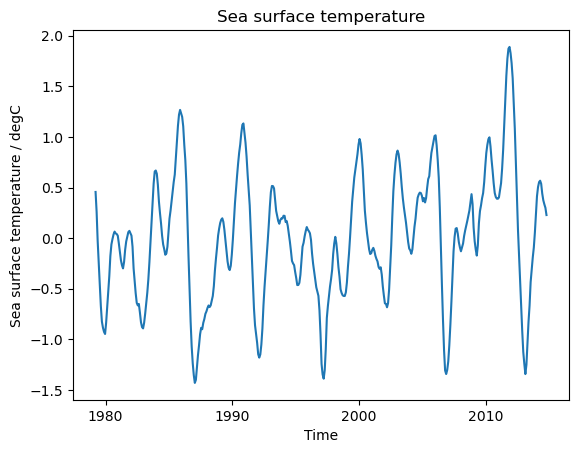

In [13]:
qplt.plot(nino3_4ssta(var.load()))